In [8]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pdr.get_data_yahoo('TATASTEEL.NS')

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-08-16,60.274883,59.112545,59.546040,60.136738,76939845.0,24.401810
2017-08-17,60.689323,59.460293,60.031937,59.584148,48456307.0,24.177586
2017-08-18,59.903316,59.079201,59.303093,59.607967,35541878.0,24.187250
2017-08-21,60.846523,58.983925,60.298702,59.217346,43827924.0,24.028748
2017-08-22,60.017643,58.536140,60.017643,59.031563,38737966.0,23.953360


In [9]:
df1 = df['Close']

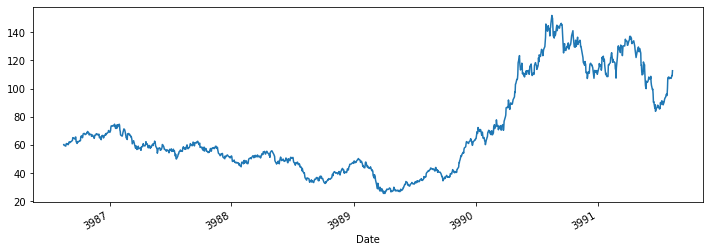

In [11]:
df1.plot(figsize=(12,4));

In [14]:
#Since LSTM are sensitive to the scale of the data so we'll apply MinMax Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1.shape

(1235, 1)

In [17]:
print(df1)

[[0.27465521]
 [0.27028916]
 [0.27047736]
 ...
 [0.66230787]
 [0.66151777]
 [0.68956662]]


In [18]:
##splitting dataset into train and test split
train_size = int(len(df1)*0.70)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]

In [23]:
#time steps
def dataset_create(df,time_step=1):
    data_X, data_Y = [], []
    for i in range(len(df) - time_step-1):
        a = df[i:(i+time_step),0]
        data_X.append(a)
        data_Y.append(df[i+time_step,0])
    return np.array(data_X), np.array(data_Y)

In [24]:
#reshape into X = t, t+1, t+2, t+3 and Y = t+4
time_step = 100
X_train, y_train = dataset_create(train_data, time_step)
X_test, y_test = dataset_create(test_data, time_step)

In [27]:
X_train.shape, y_train.shape

((763, 100), (763,))

In [28]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [29]:
#reshaping 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [33]:
#create the stacked lstm model
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [58]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [63]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam', 'rmsprop','sgd','adadelta']}
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5,scoring=None)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
model=grid_search.best_estimator_

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 15s 527ms/step - loss: 0.0134 - val_loss: 0.1161
Epoch 2/100
12/12 [==============================] - 3s 293ms/step - loss: 0.0032 - val_loss: 0.0302
Epoch 3/100
12/12 [==============================] - 4s 290ms/step - loss: 0.0016 - val_loss: 0.0160
Epoch 4/100
12/12 [==============================] - 4s 297ms/step - loss: 8.9962e-04 - val_loss: 0.0046
Epoch 5/100
12/12 [==============================] - 3s 273ms/step - loss: 8.3006e-04 - val_loss: 0.0044
Epoch 6/100
12/12 [==============================] - 3s 290ms/step - loss: 7.4123e-04 - val_loss: 0.0052
Epoch 7/100
12/12 [==============================] - 3s 288ms/step - loss: 6.9226e-04 - val_loss: 0.0050
Epoch 8/100
12/12 [==============================] - 3s 283ms/step - loss: 6.6415e-04 - val_loss: 0.0038
Epoch 9/100
12/12 [==============================] - 4s 295ms/step - loss: 6.2207e-04 - val_loss: 0.0036
Epoch 10/100
12/12 [==============================] - 4s 298ms/ste

12/12 [==============================] - 2s 200ms/step - loss: 2.1464e-04 - val_loss: 0.0022
Epoch 79/100
12/12 [==============================] - 2s 199ms/step - loss: 2.2031e-04 - val_loss: 0.0031
Epoch 80/100
12/12 [==============================] - 2s 177ms/step - loss: 2.1151e-04 - val_loss: 0.0029
Epoch 81/100
12/12 [==============================] - 2s 189ms/step - loss: 2.0931e-04 - val_loss: 0.0024
Epoch 82/100
12/12 [==============================] - 2s 197ms/step - loss: 2.1032e-04 - val_loss: 0.0033
Epoch 83/100
12/12 [==============================] - 3s 242ms/step - loss: 2.0991e-04 - val_loss: 0.0032
Epoch 84/100
12/12 [==============================] - 3s 237ms/step - loss: 1.9757e-04 - val_loss: 0.0017
Epoch 85/100
12/12 [==============================] - 2s 201ms/step - loss: 2.1996e-04 - val_loss: 0.0012
Epoch 86/100
12/12 [==============================] - 2s 198ms/step - loss: 2.5623e-04 - val_loss: 0.0018
Epoch 87/100
12/12 [==============================] - 3s 23

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

49.12835296363861

In [41]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

113.16685059305243

No handles with labels found to put in legend.


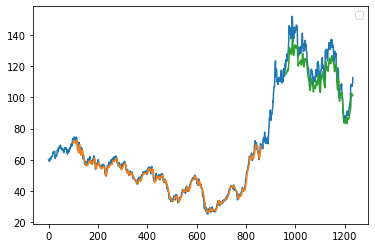

In [47]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()

In [51]:
x_input=test_data[341:].reshape(1,-1)
print(x_input.shape)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

(1, 30)


In [53]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.62180185]
31
[0.62180185]
32
[0.62180185]
33
[0.62180185]
34
[0.62180185]
35
[0.62180185]
36
[0.62180185]
37
[0.62180185]
38
[0.62180185]
39
[0.62180185]
40
[0.62180185]
41
[0.62180185]
42
[0.62180185]
43
[0.62180185]
44
[0.62180185]
45
[0.62180185]
46
[0.62180185]
47
[0.62180185]
48
[0.62180185]
49
[0.62180185]
50
[0.62180185]
51
[0.62180185]
52
[0.62180185]
53
[0.62180185]
54
[0.62180185]
55
[0.62180185]
56
[0.62180185]
57
[0.62180185]
58
[0.62180185]
59
[0.62180185]
60
[[0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531799316], [0.6218018531

In [54]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [55]:
len(df1)

1235